# Balanced network of excitatory and inhibitory neurons.

An implementation of benchmarks from Brette et al. (2007) Journal of Computational Neuroscience 23: 349-398
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2638500/ (see Fig. 24). 

In the paper, they compared simulations from NEST and NEURON. Here, we are going to simulate the balanced network with SpiNNaker.

The network is based on the COBA models of Vogels & Abbott (J. Neurosci, 2005) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6725859/ .

You can look also the explicit model in the supplementary material of Brette et al. (2007) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2638500/#APP2

<img src="../extra/VA_EXC_SPIKES.png">

In [1]:
fileName='VA_balance-network'

In [2]:
try:
    import pyNN.spiNNaker as sim
except ModuleNotFoundError:
    import pyNN.brian2 as sim
    
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
import pandas as pd
import seaborn as sns
import time
import datetime
import json
import warnings
warnings.filterwarnings('ignore')
import python_utils as pu
%matplotlib inline

savePath = f'../outputs/' # remember to create the folder if not already present (mkdir ./notebooks/outputs)
dt_string = datetime.datetime.today().isoformat() # ISO8601 ! :-)
tag = dt_string 
saveName = f'{savePath}{fileName}-{tag}'
print(saveName)
PARS={}


INFO       Cache size for target 'cython': 1184156984 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/bbpnrsoa/.cython/brian_extensions' directory. [brian2]


../outputs/VA_balance-network-2023-11-23T19:59:15.972064


# step0: import the simulator

In [3]:
import socket
try:
    import pyNN.spiNNaker as sim
except ModuleNotFoundError:
    import pyNN.brian2 as sim
    
from pyNN.random import NumpyRNG, RandomDistribution
from pyNN.utility.plotting import Figure, Panel
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time
from pyNN import space 

# step1: setup the simulator

In [4]:
dt = 1          # (ms) simulation timestep
tstop = 1000      # (ms) simulaton duration
delay = 2 # (ms) 

sim.setup(
    timestep=dt, 
    min_delay=delay, 
    max_delay=delay) # [ms] # not that the max_delay supported by SpiNNaker is timestep * 144

rngseed = 98766987
rng = NumpyRNG(seed=rngseed, parallel_safe=True)

# step2: decide the cell types and parameters

In [5]:
# cell type
celltype = sim.IF_cond_exp
#  Leaky integrate and fire model with fixed threshold and exponentially-decaying post-synaptic conductance.
#  http://neuralensemble.org/docs/PyNN/_modules/pyNN/standardmodels/cells.html#IF_cond_exp
    
# Cell parameters
area = 20000.     # (µm²)
tau_m = 20.       # (ms)
cm = 1.           # (µF/cm²)
g_leak = 5e-5     # (S/cm²)

E_leak = None
E_leak = -60.  # (mV)
v_thresh = -50.   # (mV)
v_reset = -60.    # (mV)
t_refrac = 5.     # (ms) (clamped at v_reset)
v_mean = -60.     # (mV) mean membrane potential, for calculating CUBA weights
tau_exc = 5.      # (ms)
tau_inh = 10.     # (ms)
Erev_exc = 0.     # (mV)
Erev_inh = -80.   # (mV)

# === Calculate derived parameters ===
area = area * 1e-8                     # convert to cm²
cm = cm * area * 1000                  # convert to nF
Rm = 1e-6 / (g_leak * area)            # membrane resistance in MΩ
assert tau_m == cm * Rm                # just to check

cell_params = {'tau_m': tau_m,
               'tau_syn_E': tau_exc,
               'tau_syn_I': tau_inh,
               'v_rest': E_leak,
               'v_reset': v_reset,
               'v_thresh': v_thresh,
               'cm': cm,
               'tau_refrac': t_refrac,
               'i_offset': 0
               }

cell_params['e_rev_E'] = Erev_exc
cell_params['e_rev_I'] = Erev_inh

print(cell_params)

{'tau_m': 20.0, 'tau_syn_E': 5.0, 'tau_syn_I': 10.0, 'v_rest': -60.0, 'v_reset': -60.0, 'v_thresh': -50.0, 'cm': 0.2, 'tau_refrac': 5.0, 'i_offset': 0, 'e_rev_E': 0.0, 'e_rev_I': -80.0}


# step3: making cell populations


In [6]:
n = 1500          # number of cells
r_ei = 4.0        # number of excitatory cells:number of inhibitory cells
n_exc = int(round((n * r_ei / (1 + r_ei))))  # number of excitatory cells
n_inh = n - n_exc                            # number of inhibitory cells
print("{} {}".format(n_exc, n_inh))

pops = {
    'exc': sim.Population(
                                n_exc, 
                                celltype(**cell_params), 
                                label="Excitatory_Cells"),

    'inh': sim.Population(
                                n_inh, 
                                celltype(**cell_params), 
                                label="Inhibitory_Cells")
}

pops['exc'].record(["spikes", 'v', 'gsyn_exc', 'gsyn_inh'])
pops['inh'].record(["spikes", 'v', 'gsyn_exc', 'gsyn_inh'])


uniformDistr = RandomDistribution('uniform', [v_reset, v_thresh], rng=rng)
pops['exc'].initialize(v=uniformDistr)
pops['inh'].initialize(v=uniformDistr)

#sim.set_number_of_neurons_per_core(sim.IF_cond_exp, 50)      # this will set
# 50 neurons per core
pops.keys()

1200 300


dict_keys(['exc', 'inh'])

# step4: define the synapse types

In [7]:
# Synapse parameters
Gexc = None
Ginh = None
Gexc = 4.     # (nS) #1
Ginh = 51.    # (nS) #1
w_exc = Gexc * 1e-3              # We convert conductances to uS
w_inh = Ginh * 1e-3

exc_synapses = sim.StaticSynapse(weight=w_exc, delay=delay)
inh_synapses = sim.StaticSynapse(weight=w_inh, delay=delay)

# step5: select the connections algorithm

In [8]:
pconn = 0.02      # connection probability (2%)

exc_conn = sim.FixedProbabilityConnector(pconn, rng=rng)
inh_conn = sim.FixedProbabilityConnector(pconn, rng=rng)

# step6: make the projections

In [9]:
connections = {
    
    'e2e': sim.Projection(
        pops['exc'],
        pops['exc'], 
        exc_conn, 
        receptor_type='excitatory',
        synapse_type=exc_synapses),
    
    'e2i': sim.Projection(
        pops['exc'], 
        pops['inh'], 
        exc_conn, 
        receptor_type='excitatory',
        synapse_type=exc_synapses),
    
    'i2e': sim.Projection(
        pops['inh'], 
        pops['exc'], 
        inh_conn, 
        receptor_type='inhibitory',
        synapse_type=inh_synapses),
    
    'i2i': sim.Projection(
        pops['inh'],
        pops['inh'],
        inh_conn, 
        receptor_type='inhibitory',
        synapse_type=inh_synapses)
    
        }

connections.keys()

dict_keys(['e2e', 'e2i', 'i2e', 'i2i'])

# step7: setting the thalamic stimulus

In [10]:
n_thalamic_cells = 20 
stim_dur = 50.    # (ms) duration of random stimulation
rate = 100.       # (Hz) frequency of the random stimulation

exc_conn = None

pops['thalamus'] = sim.Population(
    n_thalamic_cells, 
    sim.SpikeSourcePoisson(rate=rate, duration=stim_dur),
    label="expoisson")
pops['thalamus'].record("spikes")


rconn = 0.01
ext_conn = sim.FixedProbabilityConnector(rconn)

connections['ext2e'] = sim.Projection(
    pops['thalamus'], 
    pops['exc'], 
    ext_conn, 
    receptor_type='excitatory',
    synapse_type=sim.StaticSynapse(weight=0.1))

connections['ext2i'] = sim.Projection(
    pops['thalamus'], 
    pops['inh'], 
    ext_conn, 
    receptor_type='excitatory',
    synapse_type=sim.StaticSynapse(weight=0.1))

connections.keys(), pops.keys()

(dict_keys(['e2e', 'e2i', 'i2e', 'i2i', 'ext2e', 'ext2i']),
 dict_keys(['exc', 'inh', 'thalamus']))

# step8: run simulation

In [11]:
tstop = 1000 # (ms)
# simulation run

tic = time.time()
sim.run(tstop)
toc = time.time() - tic

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.03s). [brian2.stateupdaters.base.method_choice]


# step9: save results

In [12]:
stateVars = {}
for pop in pops.keys():
    for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
        pops[pop].write_data(f'{saveName}-{recording}.pkl')
        stateVars[pop]=pops[pop].get_data()



# step10: recover results

In [13]:
stateVars.keys()
results = pu.recover_results(stateVars)
results.keys()

exc
gsyn_exc
gsyn_inh
v
inh
gsyn_exc
gsyn_inh
v
thalamus


dict_keys([('exc', 'gsyn_exc'), ('exc', 'gsyn_inh'), ('exc', 'v'), ('exc', 'spikes'), ('inh', 'gsyn_exc'), ('inh', 'gsyn_inh'), ('inh', 'v'), ('inh', 'spikes'), ('thalamus', 'spikes')])

# step11: postprocessing (looking at the results)

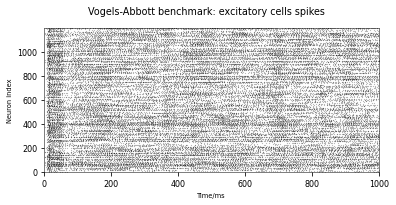

In [14]:
from pyNN.utility.plotting import Figure, Panel

Figure(
    # raster plot of the presynaptic neuron spike times
    Panel(stateVars['exc'].segments[0].spiketrains, xlabel="Time/ms", xticks=True,
          yticks=True, markersize=0.2, xlim=(0, tstop)),
    title="Vogels-Abbott benchmark: excitatory cells spikes")


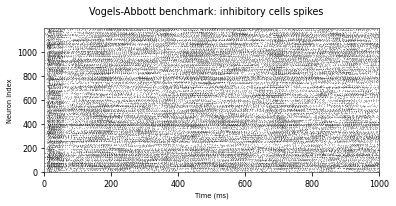

In [15]:
### from pyNN.utility.plotting import Figure, Panel

Figure(
    # raster plot of the presynaptic neuron spike times
    Panel(stateVars['exc'].segments[0].spiketrains, xlabel="Time (ms)", xticks=True,
          yticks=True, markersize=0.2, xlim=(0, tstop)),
    title="Vogels-Abbott benchmark: inhibitory cells spikes")


[Text(0, 0.5, 'Excitatory cells'), Text(0, 0.5, 'Inhibitory cells')]

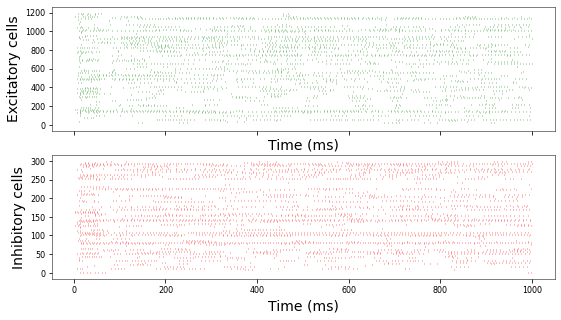

In [16]:
# classic matplotlib rasterplot function

fig, ax = plt.subplots(2,1, sharex=True, figsize=(9,5))
p0=ax[0].eventplot(results['exc', 'spikes'], color='green')
p1=ax[1].eventplot(results['inh', 'spikes'], color='red')
[ax[i].set_xlabel('Time (ms)', fontsize=14) for i in [0,1]]
[ax[i].set_ylabel(feat, fontsize=14) for i, feat in enumerate(['Excitatory cells', 'Inhibitory cells'])]

In [17]:
# check spikes

spike_rate = {
    'exc': pops['exc'].get_spike_counts(),
    'inh': pops['inh'].get_spike_counts()
}

idx=5
pop = 'exc'
print(pop + ' cell ' + str(idx) + ' :', spike_rate[pop][idx], 'spikes/' + str(tstop) + 'ms')

exc cell 5 : 11 spikes/1000ms


[Text(0.5, 0, 'membrane potential [mV]'),
 Text(0.5, 0, 'gsyn_exc [uS]'),
 Text(0.5, 0, 'gsyn_inh [uS]')]

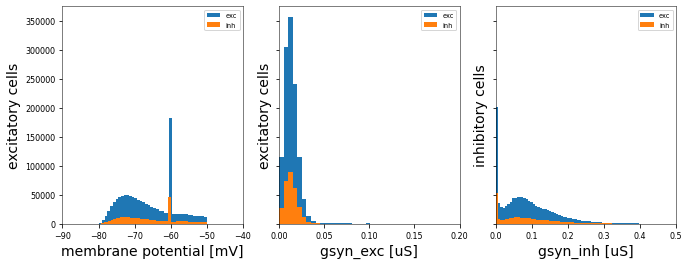

In [18]:
# check conductances and membrane voltage potentials

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(11,4), sharey=True, sharex=False)
ax = ax.flatten()
p=ax[0].hist(np.asarray(results['exc', 'v']).ravel(), 100, label='exc', log=False)
p=ax[1].hist(np.asarray(results['exc', 'gsyn_exc']).ravel(), 100, label='exc')
p=ax[2].hist(np.asarray(results['exc', 'gsyn_inh']).ravel(), 100, label='exc')

p=ax[0].hist(np.asarray(results['inh', 'v']).ravel(), 100, label='inh')
p=ax[1].hist(np.asarray(results['inh', 'gsyn_exc']).ravel(), 100, label='inh')
p=ax[2].hist(np.asarray(results['inh', 'gsyn_inh']).ravel(), 100, label='inh')

ax[0].set_xlim(-90,-40)
ax[1].set_xlim(0,0.2)
ax[2].set_xlim(0,0.5)

[ax[i].legend() for i in [0,1,2]]

[ax[i].set_ylabel('excitatory cells', fontsize=14) for i in [0,1]]
ax[2].set_ylabel('inhibitory cells', fontsize=14)
[ax[idx].set_xlabel(feat, fontsize=14) for idx, feat in enumerate(['membrane potential [mV]', 'gsyn_exc [uS]', 'gsyn_inh [uS]'])]

dict_keys([0, 1, 2])

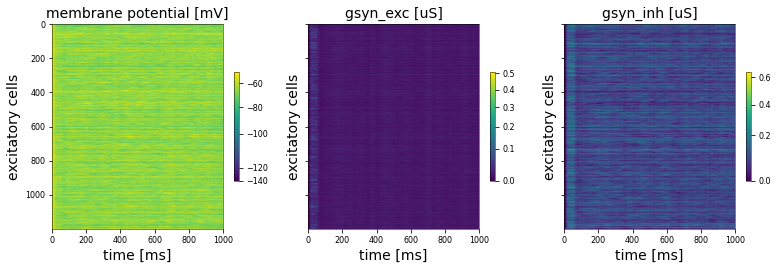

In [19]:
# voltage in excitatory pop

fig, ax = plt.subplots(1,3, figsize=(13,4), sharey=True, sharex=True)
ax = ax.flatten()

p = {}
for idx, feat in enumerate(['v', 'gsyn_exc', 'gsyn_inh']):
    p[idx] = ax[idx].imshow(np.asarray(results['exc', feat]).T,  norm=colors.PowerNorm(gamma= 0.75))

[fig.colorbar(p[idx], ax=ax[idx], shrink=0.5) for idx in [0,1,2]]

[ax[i].set_xlabel('time [ms]', fontsize=14) for i in [0,1,2]]
[ax[i].set_ylabel('excitatory cells', fontsize=14) for i in [0,1,2]]
[ax[idx].set_title(feat, fontsize=14) for idx, feat in enumerate(['membrane potential [mV]', 'gsyn_exc [uS]', 'gsyn_inh [uS]'])]

p.keys()

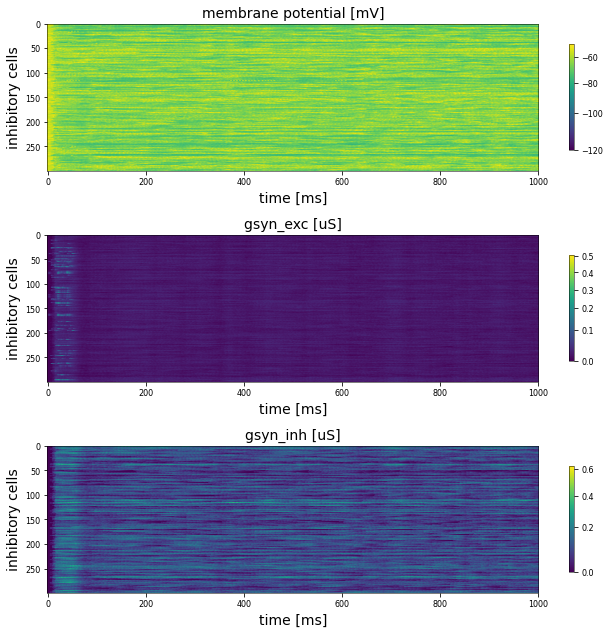

In [20]:
# voltage in inhibitory pop

fig, ax = plt.subplots(3,1, figsize=(11,11), sharey=True, sharex=False)
ax = ax.flatten()

p = {}
for idx, feat in enumerate(['v', 'gsyn_exc', 'gsyn_inh']):
    p[idx] = ax[idx].imshow(np.asarray(results['inh', feat]).T,  norm=colors.PowerNorm(gamma= 0.75))

[fig.colorbar(p[idx], ax=ax[idx], shrink=0.6) for idx in [0,1,2]]

[ax[i].set_xlabel('time [ms]', fontsize=14) for i in [0,1,2]]
[ax[i].set_ylabel('inhibitory cells', fontsize=14) for i in [0,1,2]]
[ax[idx].set_title(feat, fontsize=14) for idx, feat in enumerate(['membrane potential [mV]', 'gsyn_exc [uS]', 'gsyn_inh [uS]'])]

rasterplot=False
if rasterplot:
    for i in [0,1,2]:
        ax[i].eventplot(results['inh', 'spikes'])


In [21]:
# signal processing step, statistics, information theory tools, etc


# step12: close simulation


In [22]:
# if you run it, you cannot reload some cells, but it is needed to restart the overall simulation

sim.end()

## Task 1: on the self sustained acitivity conditions

- in the image below, the panel a) shows the sustained activity conditions of the network. <br>
  Try different set of weights combinations for discovering different functional network configurations

<img src="./extra/VA_EXC_BALANCE.png">

- image taken from Vogels & Abbott (J. Neurosci, 2005) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6725859/,